# Functional connectivity: topology

In [1]:
# import necessary libraries
import pickle as pk
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
from rich import pretty
from statannotations.Annotator import Annotator
from tda import (persistent_homology_loop,
                 topological_features_loop)
from tqdm import tqdm

pretty.install()

sb.set_theme(style="ticks", context="paper")

results_dir = "../results/functional_connectivity_topo/"
data_dir = "../data/preprocessing/"
data_out_dir = "../data/functional_connectivity_topo/"
Path(results_dir).mkdir(parents=True, exist_ok=True)
Path(data_dir).mkdir(parents=True, exist_ok=True)
Path(data_out_dir).mkdir(parents=True, exist_ok=True)

## Load data

In [2]:
skip = 1  # factor by which the input data is to be downsampled
n_windows = 18  # per condition

# prep_data_df = pd.read_csv(f"{data_dir}EEG_{n_windows}wind_per_condition_skip_{skip}_df.csv")
prep_data_df = pk.load(
    open(f"{data_dir}EEG_{n_windows}wind_per_condition_skip_{skip}_df.pkl", "rb")
)

In [3]:
prep_data_df

,file,group,subject,condition,window,series,channels
01_ROE_0,01_ROE_0,high,01,ROE,0,"[[1.0079775810241698e-05, 2.074808597564697e-0...","[F7, F3, FZ, F4, F8, C3, C4, T7, CZ, T8, P3, P..."
01_ROE_1,01_ROE_1,high,01,ROE,1,"[[8.732605934143066e-06, 8.209209442138671e-06...","[F7, F3, FZ, F4, F8, C3, C4, T7, CZ, T8, P3, P..."
01_ROE_2,01_ROE_2,high,01,ROE,2,"[[3.9199738502502436e-06, 3.7186665534973144e-...","[F7, F3, FZ, F4, F8, C3, C4, T7, CZ, T8, P3, P..."
01_ROE_3,01_ROE_3,high,01,ROE,3,"[[-1.2703986167907715e-05, -1.1578314781188964...","[F7, F3, FZ, F4, F8, C3, C4, T7, CZ, T8, P3, P..."
01_ROE_4,01_ROE_4,high,01,ROE,4,"[[2.1931514739990233e-06, 1.0445833206176757e-...","[F7, F3, FZ, F4, F8, C3, C4, T7, CZ, T8, P3, P..."
...,...,...,...,...,...,...,...
31_POST_13,31_POST_13,low,31,POST,13,"[[-8.457123637199402e-07, -1.002213716506958e-...","[F7, F3, FZ, F4, F8, C3, C4, T7, CZ, T8, P3, P..."
31_POST_14,31_POST_14,low,31,POST,14,"[[7.061112523078918e-07, 1.639171093702316e-07...","[F7, F3, FZ, F4, F8, C3, C4, T7, CZ, T8, P3, P..."
31_POST_15,31_POST_15,low,31,POST,15,"[[-1.2990448474884034e-06, 4.855538308620453e-...","[F7, F3, FZ, F4, F8, C3, C4, T7, CZ, T8, P3, P..."
31_POST_16,31_POST_16,low,31,POST,16,"[[-2.526456117630005e-08, -5.821528434753418e-...","[F7, F3, FZ, F4, F8, C3, C4, T7, CZ, T8, P3, P..."


## Compute persistent homology

In [4]:
# persistent homology parameters
embedding = "correlation"  # corresponds to function connectivity
max_dim = 1  # maximum homology dimension
sparse = False  # whether to use the sparse approximation
epsilon = None  # correctness if sparse approximation
replace_inf = True

# topological features parameters
scaling = None  # whether and how to scale topological features

In [23]:
# compute persistent homology and store the diagrams
diagrams_dict = persistent_homology_loop(
    prep_data_df,
    max_dimension=max_dim,
    embedding_kind=embedding,
    sparse=sparse,
    epsilon=epsilon,
    replace_inf=replace_inf,
)

100%|█████████████████████████████████████| 3240/3240 [00:00<00:00, 3855.44it/s]


In [27]:
# extract topological features form each of the diagrams
topo_descriptors = topological_features_loop(
    diagrams_dict, max_dimension=max_dim, scaling=scaling
)

for dim in range(max_dim + 1):
    topo_descriptors[dim]["avg_persistence"] = topo_descriptors[dim].apply(
        lambda x: x["tot_persistence"] / x["betti"]
        if x["tot_persistence"] > 0
        else x["tot_persistence"],
        axis=1,
    )
    # topo_descriptors[dim]["tot_persistence"] / topo_descriptors[dim]["betti"]

In [28]:
topo_descriptors_labeled = dict()

for dim in range(max_dim + 1):
    # add file name and window index
    topo_descriptors_labeled[dim] = topo_descriptors[dim].merge(
        right=prep_data_df[["file"]], left_index=True, right_index=True
    )

    cols = ["file", "group", "subject", "condition"]

    # add file name and window index
    topo_descriptors_labeled[dim] = topo_descriptors_labeled[dim].merge(
        right=prep_data_df[cols], left_on="file", right_on="file"
    )

## Draw barplots of topo features

In [41]:
topo_long_df = {}

# change to long format
for dim in range(max_dim + 1):
    topo_long_df[dim] = topo_descriptors_labeled[dim].melt(
        #value_vars=["tot_persistence", "persistent_entropy", "betti"],
        value_vars=["tot_persistence", "persistent_entropy"],
        id_vars=cols,
    )

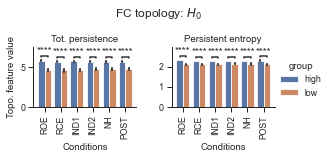

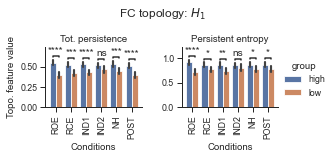

In [42]:
for dim in range(max_dim + 1):

    condition_list = topo_long_df[dim]["condition"].unique()

    g = sb.catplot(
        kind="bar",
        x="condition",
        y="value",
        hue="group",
        col="variable",
        sharey=False,
        data=topo_long_df[dim],
        col_wrap=2,
        height=2,
        aspect=1,
    )

    pairs = []
    for v in condition_list:
        pairs.append([(v, "high"), (v, "low")])
    #var = ["tot_persistence", "persistent_entropy", "betti"]
    var = ["tot_persistence", "persistent_entropy"]
    
    for ax in g.axes.flat:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

    for i, ax in enumerate(g.axes):
        mask = topo_long_df[dim]["variable"] == var[i]
        annotator = Annotator(
            ax,
            pairs,
            data=topo_long_df[dim][mask],
            x="condition",
            y="value",
            hue="group",
            col="variable",
            verbose=False,
        )
        annotator.configure(test="t-test_welch", text_format="star", loc="inside")
        annotator.apply_and_annotate()
        #titles = ["Tot. persistence", "Persistent entropy", "Betti"]
        titles = ["Tot. persistence", "Persistent entropy"]

        ax.set_title(titles[i])
        ax.set_xlabel("Conditions")

    g.axes[0].set_ylabel("Topo. feature value")
    plt.suptitle(f"FC topology: $H_{dim}$")
    plt.subplots_adjust(top=0.7)

    fig_name = f"topo_features_H{dim}_{n_windows}wind_skip_{skip}"
    plt.savefig(
        f"{results_dir}{fig_name}.png", facecolor="w", dpi=250, bbox_inches="tight"
    )

plt.show()

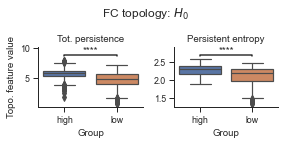

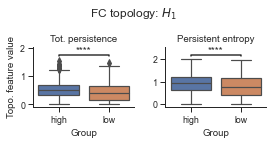

In [43]:
for dim in range(max_dim + 1):

    condition_list = topo_long_df[dim]["condition"].unique()

    g = sb.catplot(
        kind="box",
        x="group",
        y="value",
        #hue="group",
        col="variable",
        sharey=False,
        data=topo_long_df[dim],
        col_wrap=2,
        height=2,
        aspect=1,
    )

    pairs = [("high", "low")]
    #for v in condition_list:
    #    pairs.append([(v, "high"), (v, "low")])
    
    #var = ["tot_persistence", "persistent_entropy", "betti"]
    var = ["tot_persistence", "persistent_entropy"]
    
    for ax in g.axes.flat:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

    for i, ax in enumerate(g.axes):
        mask = topo_long_df[dim]["variable"] == var[i]
        annotator = Annotator(
            ax,
            pairs,
            data=topo_long_df[dim][mask],
            x="group",
            y="value",
            #hue="group",
            col="variable",
            verbose=False,
        )
        annotator.configure(test="t-test_welch", text_format="star", loc="inside")
        annotator.apply_and_annotate()
        #titles = ["Tot. persistence", "Persistent entropy", "Betti"]
        titles = ["Tot. persistence", "Persistent entropy"]

        ax.set_title(titles[i])
        ax.set_xlabel("Group")

    g.axes[0].set_ylabel("Topo. feature value")
    plt.suptitle(f"FC topology: $H_{dim}$")
    plt.subplots_adjust(top=0.7)

    fig_name = f"topo_features_group_H{dim}_{n_windows}wind_skip_{skip}"
    plt.savefig(
        f"{results_dir}{fig_name}.png", facecolor="w", dpi=250, bbox_inches="tight"
    )

plt.show()

In [44]:
topo_long_df[dim]

,file,group,subject,condition,variable,value
0,01_ROE_0,high,01,ROE,tot_persistence,0.176504
1,01_ROE_1,high,01,ROE,tot_persistence,0.459187
2,01_ROE_2,high,01,ROE,tot_persistence,0.242178
3,01_ROE_3,high,01,ROE,tot_persistence,0.624644
4,01_ROE_4,high,01,ROE,tot_persistence,0.280699
...,...,...,...,...,...,...
6475,31_POST_13,low,31,POST,persistent_entropy,0.802763
6476,31_POST_14,low,31,POST,persistent_entropy,0.626937
6477,31_POST_15,low,31,POST,persistent_entropy,0.908952
6478,31_POST_16,low,31,POST,persistent_entropy,0.788830


In [45]:
for dim in range(max_dim + 1):

    topo_long_df[dim].to_csv(f"{data_out_dir}topo_long_df_H{dim}_{n_windows}wind_skip_{skip}.csv", index=False)

In [48]:
tag = f"{n_windows}wind_skip_{skip}"

pk.dump(
    topo_descriptors_labeled,
    open(f"{data_out_dir}topo_descriptors_labeled_{tag}.pkl", "wb"),
)
# pk.dump(diagrams_dict, open(f"{data_out_dir}diagrams_dict_{tag}.pkl", "wb"))

In [47]:
topo_descriptors_labeled[0]

,tot_persistence,persistent_entropy,betti,avg_persistence,file,group,subject,condition
0,6.194047,2.198606,16,0.387128,01_ROE_0,high,01,ROE
1,5.673674,2.224342,16,0.354605,01_ROE_1,high,01,ROE
2,5.599395,2.131990,16,0.349962,01_ROE_2,high,01,ROE
3,5.779552,2.168971,16,0.361222,01_ROE_3,high,01,ROE
4,5.177297,2.173522,16,0.323581,01_ROE_4,high,01,ROE
...,...,...,...,...,...,...,...,...
3235,5.776911,2.409530,16,0.361057,31_POST_13,low,31,POST
3236,4.599415,2.251247,16,0.287463,31_POST_14,low,31,POST
3237,5.420964,2.424134,16,0.338810,31_POST_15,low,31,POST
3238,4.699219,2.163569,16,0.293701,31_POST_16,low,31,POST


## Save to file

In [37]:
diagrams_df = pd.DataFrame.from_dict(diagrams_dict, orient="index")
# diagrams_df.to_csv('../data/correlation-embedding/diagramsdf.csv', index=True)
diagrams_df

,dgms,cocycles,num_edges,dperm2all,idx_perm,r_cover
01_ROE_0,"[[[0.0, 0.013017703779041767], [0.0, 0.0206570...","[[], []]",120,"[[1.1102230246251565e-16, 0.02211821293685612,...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.0
01_ROE_1,"[[[0.0, 0.032250672578811646], [0.0, 0.0326571...","[[], []]",120,"[[0.0, 0.03265717051503236, 0.0769017888216655...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.0
01_ROE_2,"[[[2.220446049250313e-16, 0.015037293545901775...","[[], []]",120,"[[1.1102230246251565e-16, 0.017726795034393228...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.0
01_ROE_3,"[[[1.1102230246251565e-16, 0.01215977780520916...","[[], []]",120,"[[0.0, 0.014185899969882065, 0.045006483194827...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.0
01_ROE_4,"[[[0.0, 0.014383839443325996], [0.0, 0.0160974...","[[], []]",120,"[[0.0, 0.014383839724291803, 0.042678036342410...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.0
...,...,...,...,...,...,...
31_POST_13,"[[[0.0, 0.03417450934648514], [1.1102230246251...","[[], []]",120,"[[0.0, 0.2698873621238572, 0.5462948470274063,...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.0
31_POST_14,"[[[1.1102230246251565e-16, 0.02143935486674308...","[[], []]",120,"[[0.0, 0.15914887633406705, 0.5465490470404223...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.0
31_POST_15,"[[[1.1102230246251565e-16, 0.0732356607913971]...","[[], []]",120,"[[0.0, 0.12577975802894004, 0.4015192849376594...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.0
31_POST_16,"[[[0.0, 0.010171066969633102], [0.0, 0.0379404...","[[], []]",120,"[[0.0, 0.05597597549046229, 0.1463737662493335...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.0
